In [1]:
import time
import itertools
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool

from simulation import simulation
from simulation_plots import *
np.seterr(all='raise')





{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

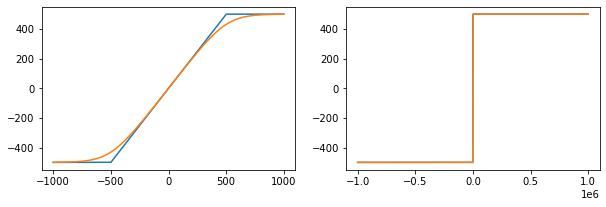

In [2]:

def smooth_clip(x, a=-500, b=500, c=0.01):
    results = []
    for xi in x:
        try:
            results.append(xi - 1/c * np.log(1 + np.exp(c * (xi - b))) + 1/c * np.log(1 + np.exp(-c* (xi - a))))
        except:
            if xi > b:
                results.append(b)
            if xi < a:
                results.append(a)
    return np.array(results)

    
fig, axs = plt.subplots(1, 2, figsize = (10, 3))

x = np.linspace(-1000, 1000, num=100000)
axs[0].plot(x, np.clip(x, -500, 500))
axs[0].plot(x, smooth_clip(x, -500, 500, 0.01))

x = np.array(np.linspace(-1000000, 1000000, num=1000000))
axs[1].plot(x, np.clip(x, -500, 500))
axs[1].plot(x, smooth_clip(x, -500, 500, 0.01))

plt.show()

In [3]:
def objective_function(beta, X, y, rewards, propensity_scores, l = 0.1, S = 1, use_smooth_clip = False, 
                       correct_min_count = None, miss_min = None, intercept = False, pelnalty_norm = False):
#######     clip_func = smooth_clip if use_smooth_clip else lambda x: np.clip(x, -500, 500)


    clip_func = smooth_clip if use_smooth_clip else lambda x: x
    all_loss = 0
    for pid, covariates in X.items():
        assignments = np.array(y[pid])
        reward = rewards[pid]
        if intercept:
            func_outputs =  np.array([np.matmul(beta, np.hstack([1, var])) for var in covariates]) 
        else:
            func_outputs =  np.array([np.matmul(beta, var) for var in covariates])
                    
        pscore = propensity_scores[pid]
        asy_min = -np.log(np.sum(np.exp(clip_func(-func_outputs * assignments) * S))) / S
        pid_loss = -(reward * -np.log(1 + np.exp(clip_func(-np.array([asy_min])))) / pscore)
        all_loss = pid_loss + all_loss
               
        if correct_min_count is not None and miss_min is not None:
            if np.all(np.abs(func_outputs * assignments - asy_min) >= np.abs(min(func_outputs * assignments) - asy_min)):
                correct_min_count[1] += 1
            miss_min.append(func_outputs * assignments)
            correct_min_count[0] += 1

    if pelnalty_norm:
        all_loss = 1 / len(X) * all_loss + l * (np.sum(beta**2) - 1)
    else:
        all_loss = 1 / len(X) * all_loss + l * np.sum(beta**2)
    return all_loss

In [4]:
def multi_job(params):
    l, S, x0, x_distr, args = params
    results = defaultdict(lambda: pd.DataFrame())
    np.random.seed(1)
    sim = simulation(optimal_decision_rule, Q0, VF, objective_function, x_distr, balanced = True, n=1000)
    sim.generate_data(*args)
    try:
        results['original'] = sim.optimize(l, S, x0=x0, scale = False, smooth_clip=True, lb = -np.inf, up = np.inf, intercept = 0, penalty_norm = False)
        results['original_intercept'] = sim.optimize(l, S, x0=x0, scale = False, smooth_clip=True, lb = -np.inf, up = np.inf, intercept = 0.5, penalty_norm = False)
        results['scaled'] = sim.optimize(l, S, x0=x0, scale = True, smooth_clip=True, lb = -np.inf, up = np.inf, intercept = 0, penalty_norm = False)
        results['scaled_intercept'] = sim.optimize(l, S, x0=x0, scale = True, smooth_clip=True, lb = -np.inf, up = np.inf, intercept = 0.5, penalty_norm = False)
        results['boundary_1'] = sim.optimize(l, S, x0=x0, scale = False, smooth_clip=False, lb = -1, up = 1, intercept = 0.5, penalty_norm = False)
        results['boundary_5'] = sim.optimize(l, S, x0=x0, scale = False, smooth_clip=False, lb = -5, up = 5, intercept = 0.5, penalty_norm = False)
        results['norm_penalty'] = sim.optimize(l, S, x0=x0, scale = False, smooth_clip=True, lb = -np.inf, up = np.inf, intercept = 0.5, penalty_norm = True)
    except:
        return dict(results)
    return dict(results)

def run_simulations(l_list, S_list, x0, x_distr, args):
    np.random.seed(1)
    pool = Pool(processes=8)
    master = defaultdict(lambda: pd.DataFrame())
    for res in pool.imap_unordered(multi_job, [[i, j, x0, x_distr, args] for i, j in itertools.product(l_list, S_list)]):
        for k in res:
            master[k] = pd.concat([master[k], res[k]], axis = 0)   
    pool.close()
    pool.join()
    
    for k in master:
        num_betas = len(master[k].iloc[0]['Betas'].split())
        b_names = ['b{}'.format(i) for i in range(num_betas)]
        b_dist_names = ['b{}_dist'.format(i) for i in range(num_betas)]
        master[k] = master[k].reset_index(drop = True)
        master[k][b_names] = master[k]['Betas'].str.split(' ', expand=True).astype('float64')
        if num_betas == len(optimal_betas) + 1:
            master[k][b_dist_names[1:]] = np.abs(master[k][b_names[1:]] - optimal_betas)
    return master

In [5]:
optimal_decision_rule = lambda x, pid=None, idx=None: 0.5 + 0.4 * x[0] - 0.32 * x[1] - 0.71 * x[2]
Q0 = lambda x, o, a: 1 + 2 * x[0] + x[1] + 0.5 * x[2] + o*a
VF = lambda x_dict, x_dict_scaled, assignment_rule: \
    np.mean([np.sum([Q0(x_dict[pid][idx], 
                        np.sign(optimal_decision_rule(x_dict[pid][idx])), 
                        np.sign(assignment_rule(x_dict_scaled[pid][idx], pid, idx)))
                     for idx in range(x_dict[pid].shape[0])]) for pid in x_dict])

optimal_betas = np.array([0.4, -0.32, -0.71])

x0 = np.array(optimal_betas) + np.random.normal(0, 0.05, 3)
print('Optimal Betas:  ', optimal_betas)
print("Initialized x0:   ", x0)

Optimal Betas:   [ 0.4  -0.32 -0.71]
Initialized x0:    [ 0.38464712 -0.35609839 -0.60073461]


### Uniform Distribution

In [6]:
def x_distr(*x, size=1):
    return np.random.uniform(*x, size=size)

#### Unif(-1, 1)

In [7]:
args = (-1, 1)
t1 = time.time()
master_unif_1 = run_simulations([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [1,5,10], x0, x_distr, args)
t2 = time.time()
print(t2 - t1)

56.11322784423828


original


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2
1,0.4,5,100,82.3,15.62,8.25615,5.16865,5.6499,0.11 0.03 -0.01,0.11,0.03,-0.01


original_intercept


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.5,1,100,82.3,46.88,8.25615,6.80615,5.6499,1.6 0.18 0.05 -0.02,1.6,0.18,0.05,-0.02,0.22,0.37,0.69


scaled


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2
0,0.5,1,100,82.3,46.88,8.25615,6.80615,5.6499,0.98 0.89 0.84,0.98,0.89,0.84


scaled_intercept


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.5,1,100,82.3,46.88,8.25615,6.80615,5.6499,1.16 0.62 0.56 0.53,1.16,0.62,0.56,0.53,0.22,0.88,1.24


boundary_1


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.5,1,100,82.3,46.88,8.25615,6.80615,5.6499,1.0 0.23 0.07 -0.03,1,0.23,0.07,-0.03,0.17,0.39,0.68


boundary_5


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.5,1,100,82.3,46.88,8.25615,6.80615,5.6499,1.6 0.18 0.05 -0.02,1.6,0.18,0.05,-0.02,0.22,0.37,0.69


norm_penalty


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.5,1,100,82.3,46.88,8.25615,6.80615,5.6499,1.6 0.18 0.05 -0.02,1.6,0.18,0.05,-0.02,0.22,0.37,0.69


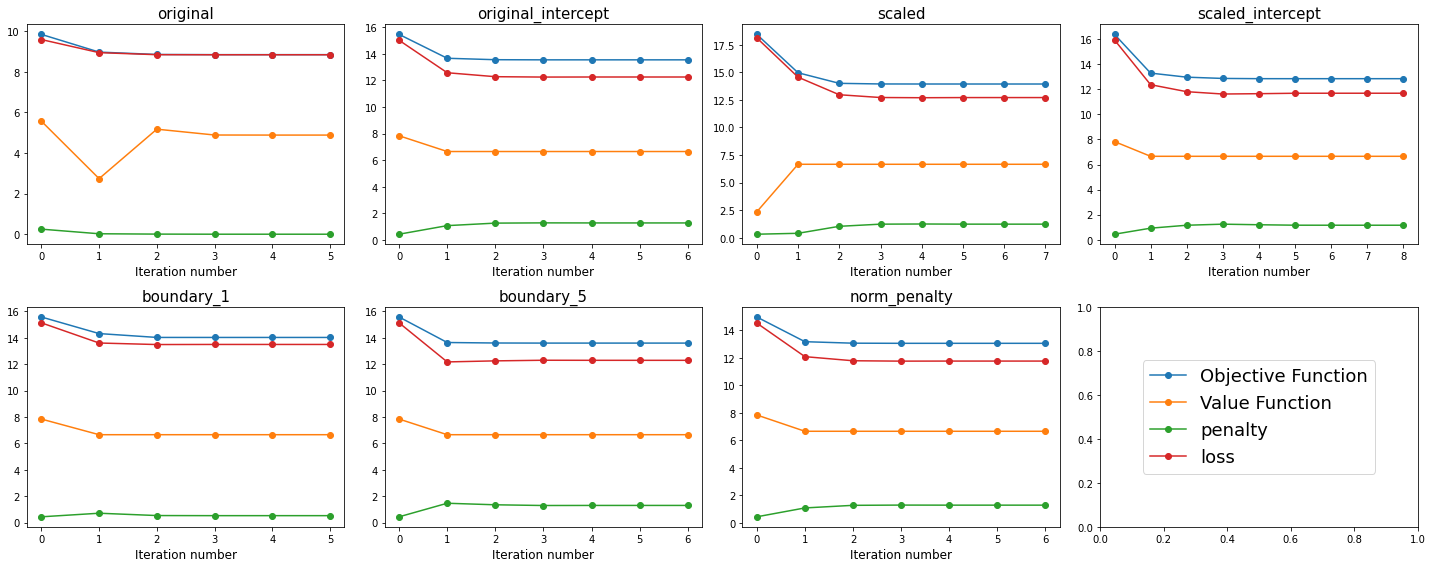

In [8]:
sim = simulation(optimal_decision_rule, Q0, VF, objective_function, x_distr, balanced = True, n=1000)
auto_plot_iterations(master_unif_1, x0, sim, -1, 1)

original


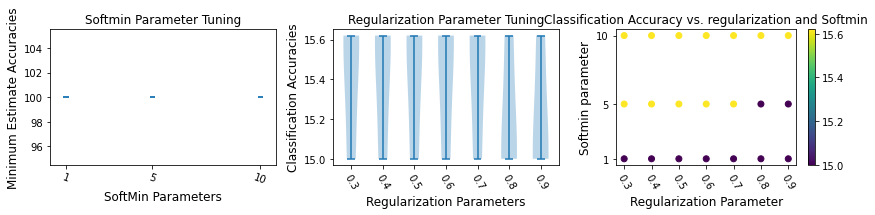

original_intercept


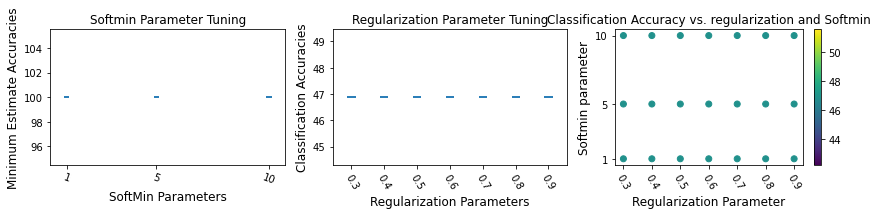

scaled


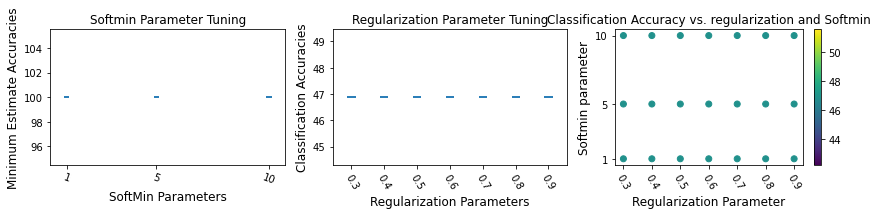

scaled_intercept


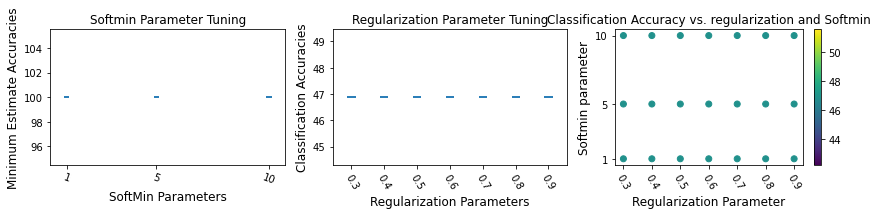

boundary_1


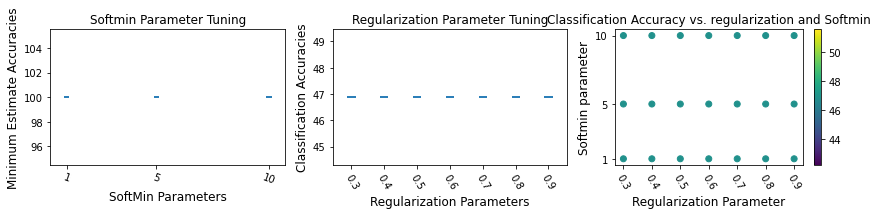

boundary_5


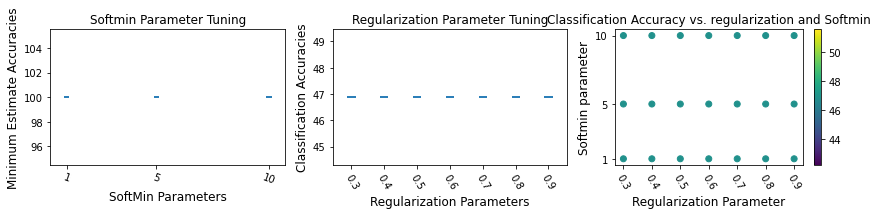

norm_penalty


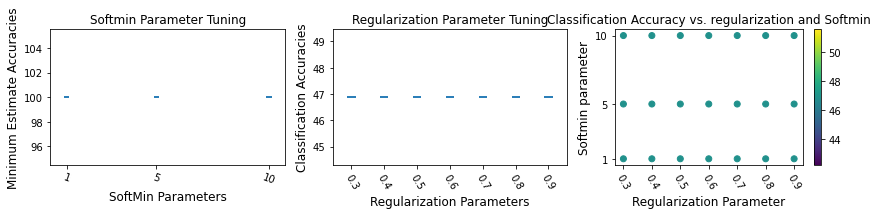

In [9]:
auto_plot_results(master_unif_1)

#### Unif(-5, 5)

In [10]:
args = (-5, 5)
t1 = time.time()
master_unif_5 = run_simulations([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [1,5,10], x0, x_distr, args)
t2 = time.time()
print(t2 - t1)

73.5348310470581


original


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2
0,0.4,1,99.99,56.78,7.5,9.28077,5.28077,5.54952,8.96 5.95 3.41,8.96,5.95,3.41


original_intercept


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.4,1,99.99,56.78,8.12,9.28077,5.26827,5.54952,1.29 8.92 6.07 3.44,1.29,8.92,6.07,3.44,8.52,6.39,4.15


scaled


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2
0,0.4,1,100,56.78,5.62,9.28077,5.73077,5.54952,1.23 0.87 0.63,1.23,0.87,0.63


scaled_intercept


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.4,1,100,56.78,5.62,9.28077,5.73077,5.54952,0.88 0.89 0.65 0.48,0.88,0.89,0.65,0.48,0.49,0.97,1.19


boundary_1


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
1,0.4,5,100,56.78,3.75,9.28077,4.73077,5.54952,0.41 1.0 1.0 0.7,0.41,1,1,0.7,0.6,1.32,1.41


boundary_5


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
8,0.8,1,100,56.78,8.12,9.28077,5.28077,5.54952,0.58 4.67 3.12 1.84,0.58,4.67,3.12,1.84,4.27,3.44,2.55


norm_penalty


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.4,1,99.99,56.78,8.12,9.28077,5.26827,5.54952,1.29 8.92 6.07 3.44,1.29,8.92,6.07,3.44,8.52,6.39,4.15


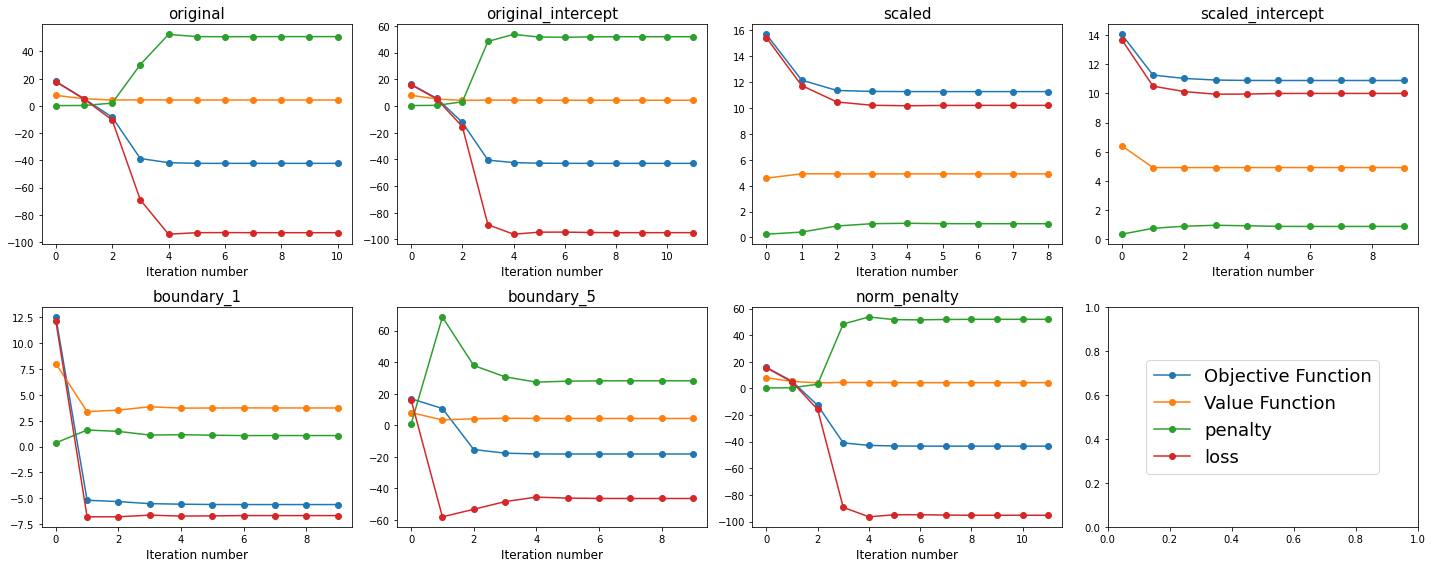

In [11]:
sim = simulation(optimal_decision_rule, Q0, VF, objective_function, x_distr, balanced = True, n=1000)
auto_plot_iterations(master_unif_5, x0, sim, -5, 5)

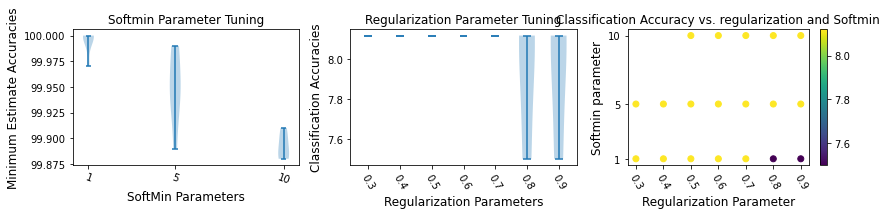

In [12]:
plot_results(master_unif_5['original_intercept'])

original


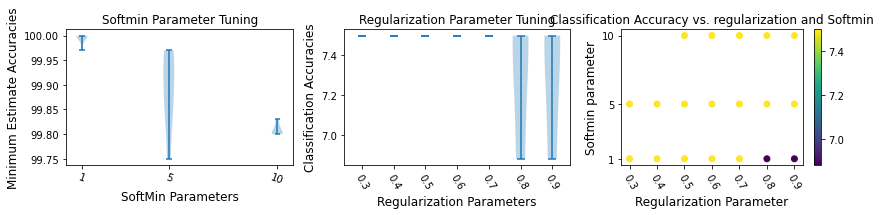

original_intercept


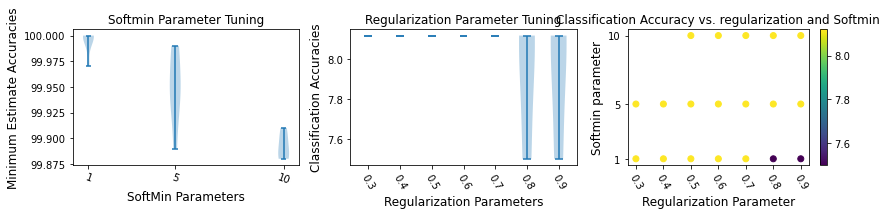

scaled


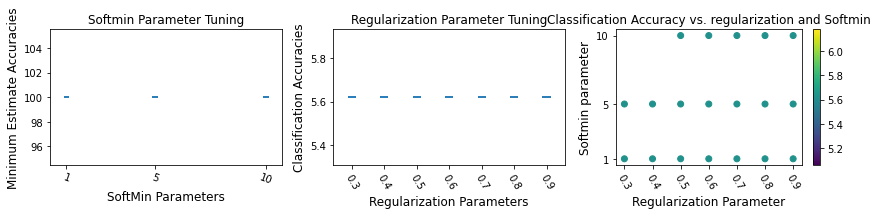

scaled_intercept


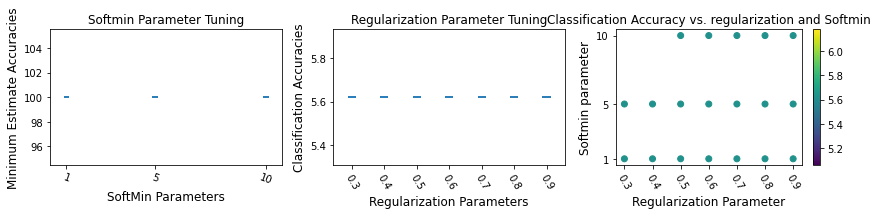

boundary_1


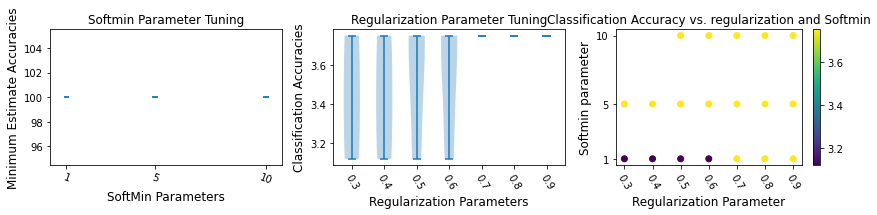

boundary_5


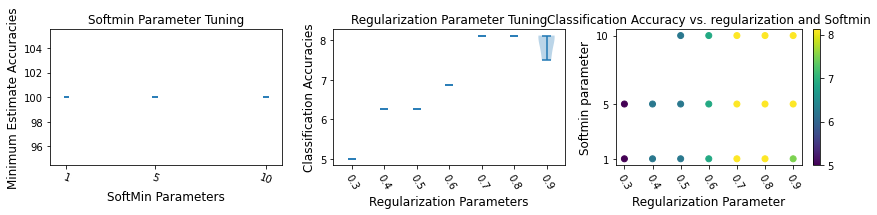

norm_penalty


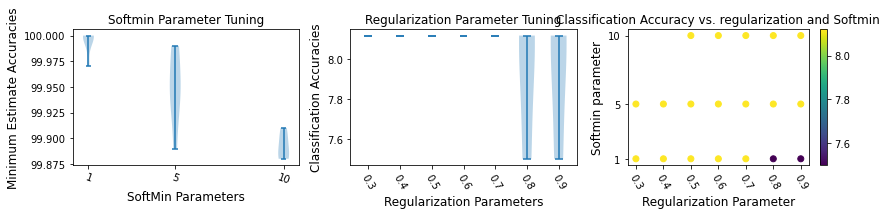

In [13]:
auto_plot_results(master_unif_5)

## Normal Distribution

In [14]:
def x_distr(*x, size=1):
    return np.random.normal(*x, size=size)

#### Normal(0, 1)

In [15]:
args = (0, 1)
t1 = time.time()
master_normal_0_1 = run_simulations([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [1,5,10], x0, x_distr, args)
t2 = time.time()
print(t2 - t1)

60.79263114929199


original


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2
0,0.4,1,100,72.15,11.25,7.69679,4.37179,4.52804,0.49 0.14 -0.03,0.49,0.14,-0.03


original_intercept


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.4,1,100,72.15,23.75,7.69679,5.30929,4.52804,1.61 0.33 0.09 -0.01,1.61,0.33,0.09,-0.01,0.07,0.41,0.7


scaled


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2
0,0.4,1,100,72.15,23.75,7.69679,5.30929,4.52804,0.98 1.03 0.89,0.98,1.03,0.89


scaled_intercept


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.4,1,100,72.15,23.75,7.69679,5.30929,4.52804,1.17 0.62 0.65 0.56,1.17,0.62,0.65,0.56,0.22,0.97,1.27


boundary_1


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
5,0.5,1,100,72.15,25,7.69679,5.34679,4.52804,1.0 0.36 0.1 -0.01,1,0.36,0.1,-0.01,0.04,0.42,0.7


boundary_5


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.4,1,100,72.15,23.75,7.69679,5.30929,4.52804,1.62 0.32 0.09 -0.01,1.62,0.32,0.09,-0.01,0.08,0.41,0.7


norm_penalty


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.4,1,100,72.15,23.75,7.69679,5.30929,4.52804,1.61 0.33 0.09 -0.01,1.61,0.33,0.09,-0.01,0.07,0.41,0.7


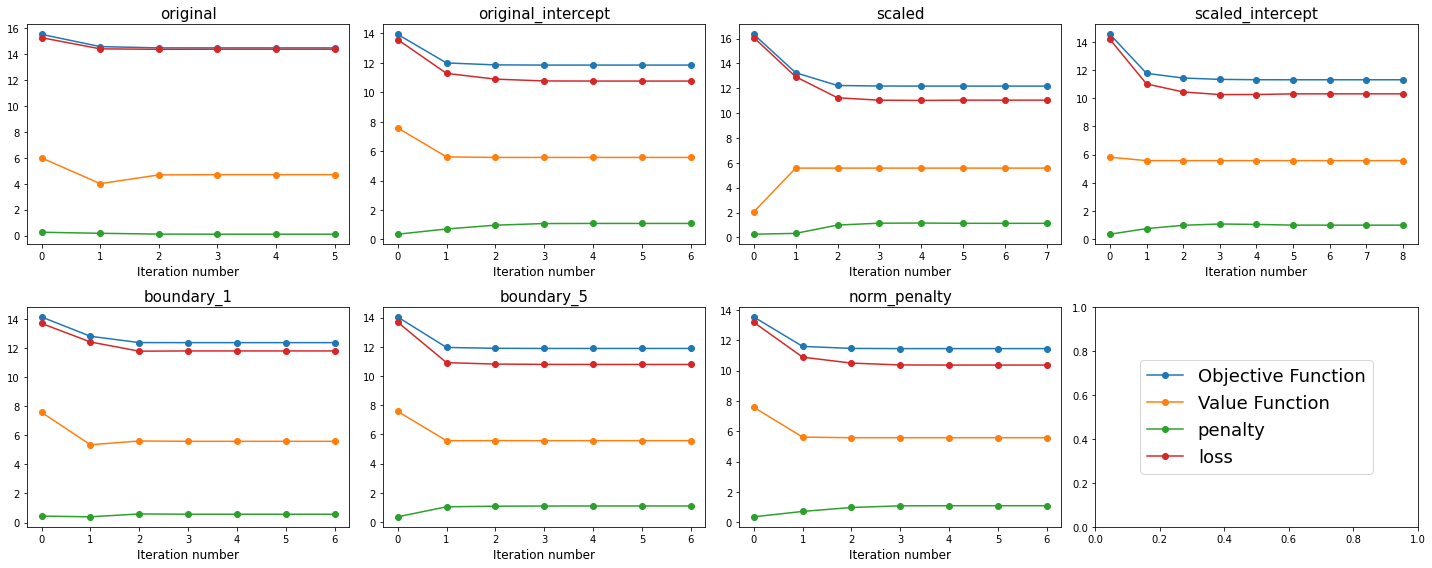

In [16]:
sim = simulation(optimal_decision_rule, Q0, VF, objective_function, x_distr, balanced = True, n=1000)
auto_plot_iterations(master_normal_0_1, x0, sim, 0, 1)

original


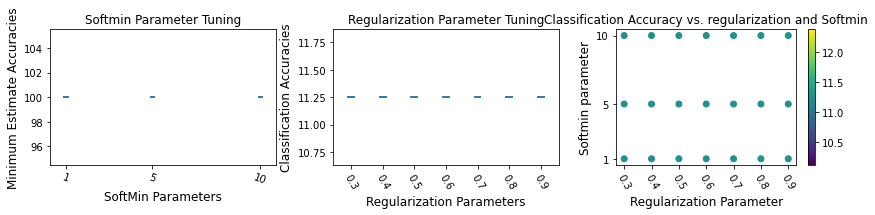

original_intercept


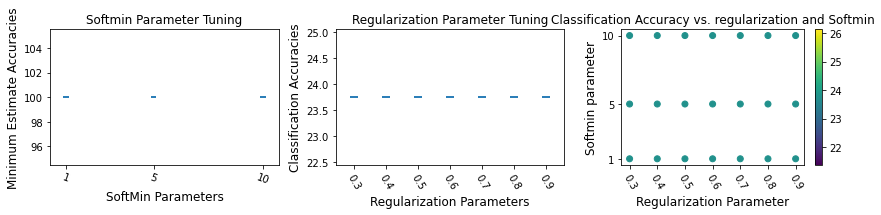

scaled


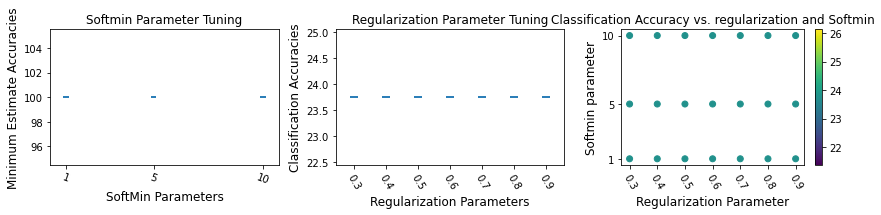

scaled_intercept


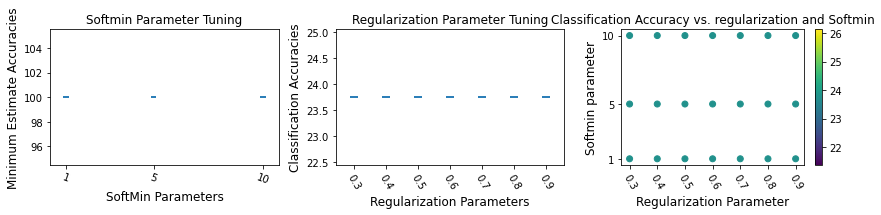

boundary_1


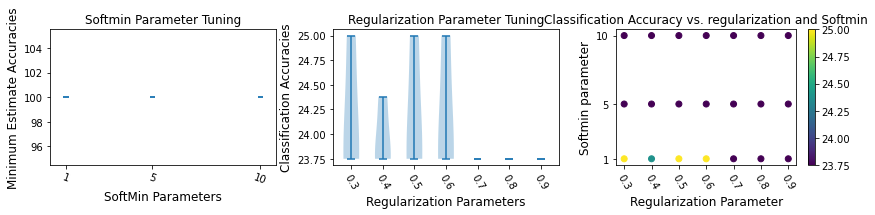

boundary_5


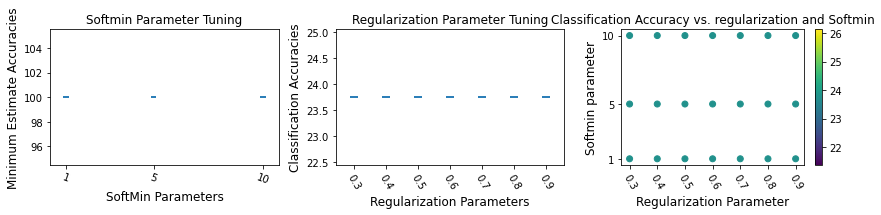

norm_penalty


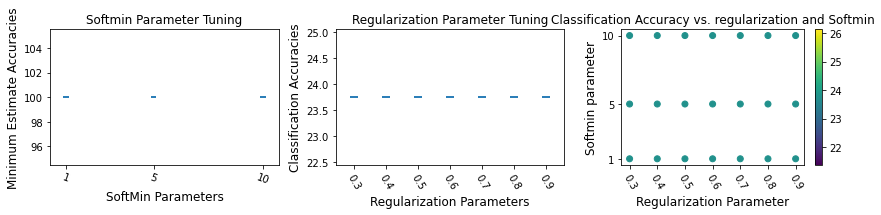

In [17]:
auto_plot_results(master_normal_0_1)

#### Normal(0, 5)

In [18]:
args = (0, 5)
t1 = time.time()
master_normal_0_5 = run_simulations([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [1,5,10], x0, x_distr, args)
t2 = time.time()
print(t2 - t1)

29.653531551361084


original


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2
6,0.3,1,98.54,54.62,5.62,6.48395,2.50895,2.6902,39.94 13.08 10.09,39.94,13.08,10.09


original_intercept


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.9,1,99.74,54.62,4.38,6.48395,2.34645,2.6902,-1.28 21.66 6.78 7.44,-1.28,21.66,6.78,7.44,21.26,7.1,8.15


scaled


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2
0,0.9,1,100,54.62,6.88,6.48395,2.73395,2.6902,0.69 0.5 0.41,0.69,0.5,0.41


scaled_intercept


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.9,1,100,54.62,6.88,6.48395,2.73395,2.6902,0.56 0.55 0.4 0.33,0.56,0.55,0.4,0.33,0.15,0.72,1.04


boundary_1


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.9,1,100,54.62,1.88,6.48395,1.04645,2.6902,-1.0 1.0 1.0 1.0,-1,1,1,1,0.6,1.32,1.71


boundary_5


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.9,1,100,54.62,1.88,6.48395,1.05895,2.6902,-1.32 5.0 5.0 4.93,-1.32,5,5,4.93,4.6,5.32,5.64


norm_penalty


,l,S,MinAccuracy,Assign_Rate,Accuracy,OptimalVF,EstimatedVF,ObservedVF,Betas,b0,b1,b2,b3,b1_dist,b2_dist,b3_dist
0,0.9,1,99.74,54.62,4.38,6.48395,2.34645,2.6902,-1.28 21.66 6.78 7.44,-1.28,21.66,6.78,7.44,21.26,7.1,8.15


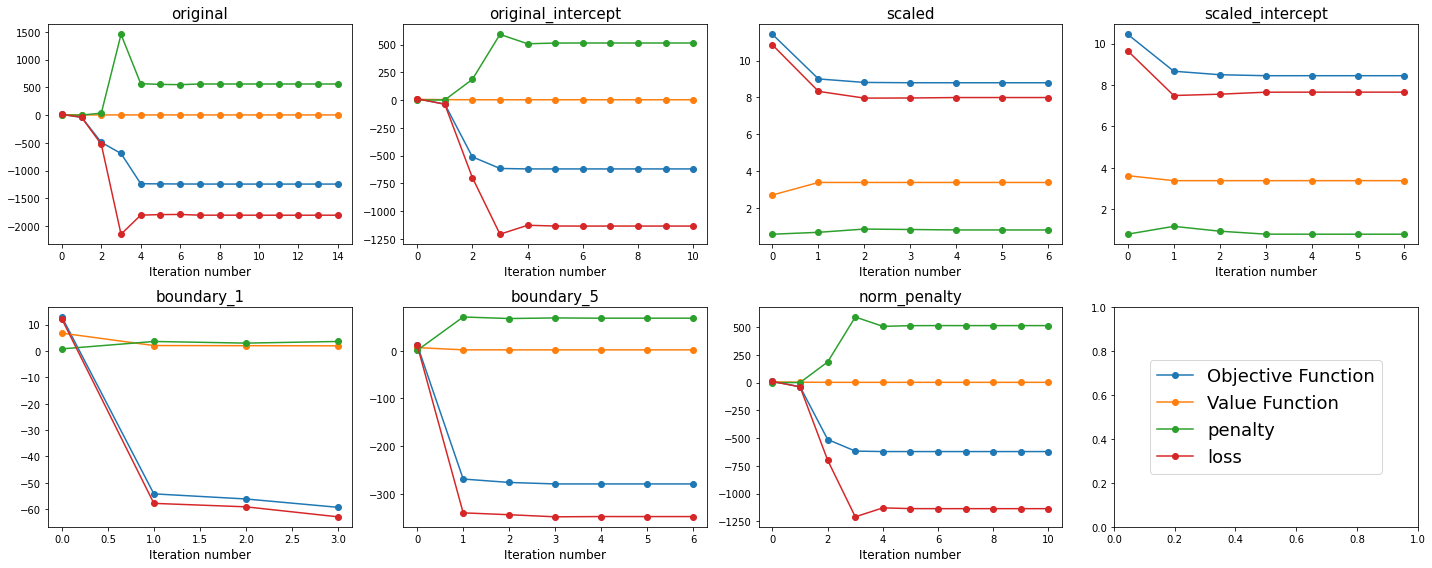

In [19]:
sim = simulation(optimal_decision_rule, Q0, VF, objective_function, x_distr, balanced = True, n=1000)
auto_plot_iterations(master_normal_0_5, x0, sim, 0, 5)

original


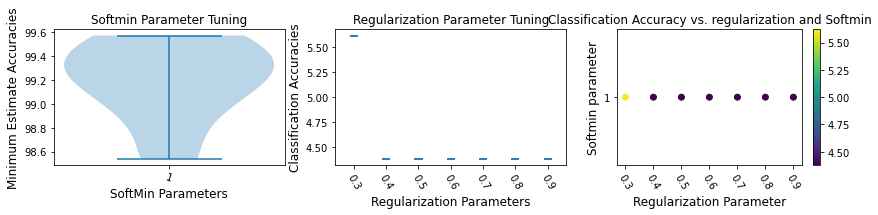

original_intercept


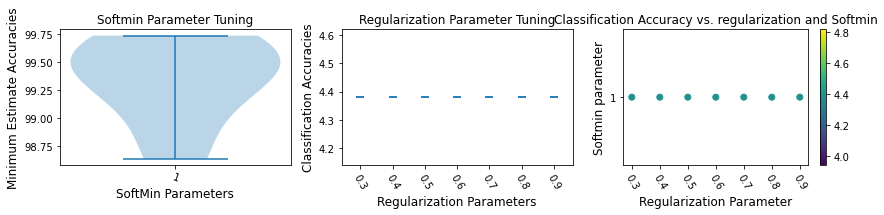

scaled


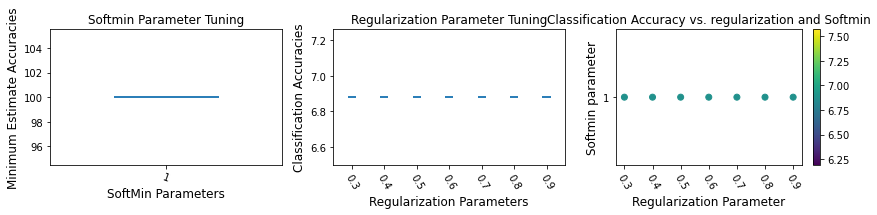

scaled_intercept


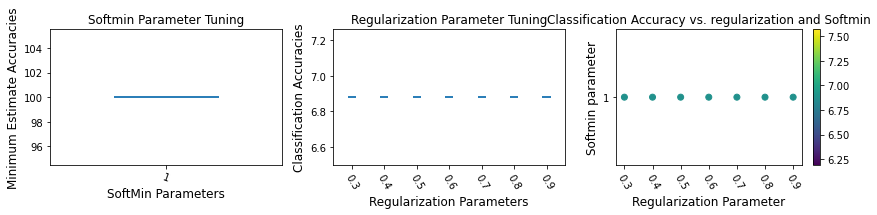

boundary_1


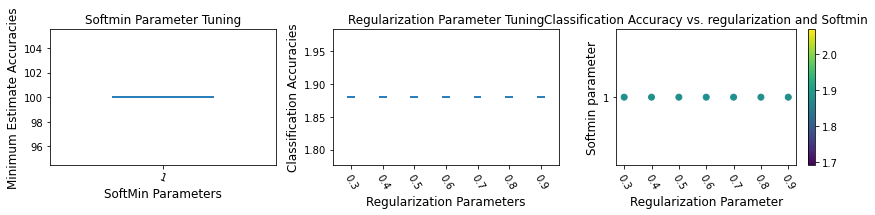

boundary_5


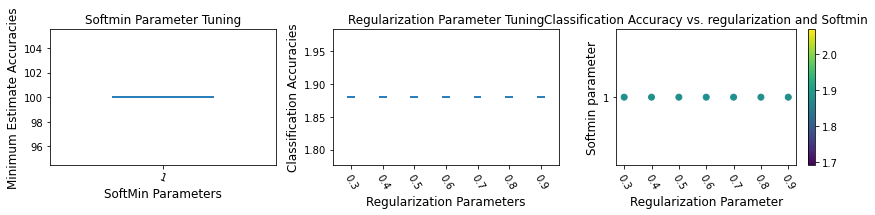

norm_penalty


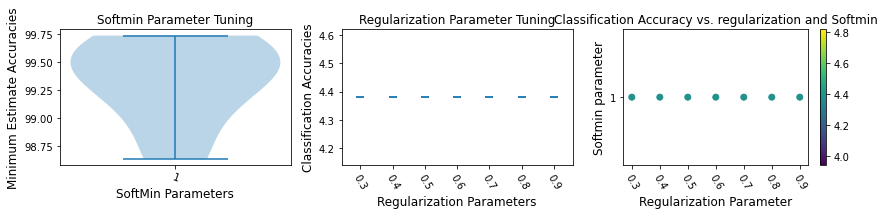

In [20]:
auto_plot_results(master_normal_0_5)